In [31]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pathlib
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
import keras

import cleaningTweets

In [32]:
# Loading the dataset 
data_dir = pathlib.Path('/home/lv11/Documents/ProyectosPython/sentimentAnalysis/train')
nf = pd.read_csv(data_dir / 'tweetsDataset1.csv',skiprows=1,names=['Message','Target'])
#print(nf.head(20))

nlp = English()
stop_words = list(STOP_WORDS)
#print(stop_words)

def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuation ]
    return tokens

In [33]:
cleaner = cleaningTweets.Cleaner()

In [34]:
vectorizer = CountVectorizer(min_df=0, lowercase=False, tokenizer=cleaner.spacy_tokenizer)
vectorizer.fit(nf['Message'])
#print(vectorizer.vocabulary_)

vectorizer.transform(nf['Message']).toarray()

messages = nf['Message']
labels = nf['Target']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(messages,labels,test_size=0.25,random_state=1000,shuffle=True)

print(len(x_train))
print(len(x_test))
print(x_test)

1727
576
108                          .Thanks so much for the RT.1
501             Why? You don't like blonde hair? unhappy 
834                           25x25? I can go first happy
584      wow whattay decision both parties celebrating :D
1148                   Please return the jacket unhappy  
                              ...                        
236     are dying of thirst  and it's all because of u...
2071    thanks for the recent follow. Much appreciated...
1811                            because you are one happy
1299    That was a FUN night! Sorry I missed last nigh...
1367                 much appreciated happy   Want this ?
Name: Message, Length: 576, dtype: object


In [38]:
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train).toarray()
X_test = vectorizer.transform(x_test).toarray()

KeyboardInterrupt: 

In [21]:
features = 3176 #3749 #1549 #1998 #2817 #3603 #3749
shufle = True
drop = 0.5
layer1 = 512 #512
layer2 = 256 #256
epoch = 5
lr = 0.002
epsilon = 1e-9
validation = 0.1

In [22]:
model = Sequential()
model.add(layers.Dense(layer1, input_dim=features, activation='relu'))
model.add(layers.Dropout(drop))
model.add(layers.Dense(layer2,activation='sigmoid'))
model.add(layers.Dropout(drop))
model.add(layers.Dense(3,activation='softmax'))

In [23]:
optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon,decay=0.0,amsgrad=False)

In [24]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               1626624   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 1,758,723
Trainable params: 1,758,723
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(np.array(X_train),y_train,batch_size=32,epochs=epoch,verbose=1,validation_split=validation,shuffle=shufle)


Train on 1554 samples, validate on 173 samples
Epoch 1/5
1554/1554 [==============================] - 3s 2ms/step - loss: 0.4926 - accuracy: 0.7516 - val_loss: 0.1648 - val_accuracy: 0.9191
Epoch 2/5
1554/1554 [==============================] - 3s 2ms/step - loss: 0.1211 - accuracy: 0.9492 - val_loss: 0.1763 - val_accuracy: 0.9249
Epoch 3/5
1554/1554 [==============================] - 3s 2ms/step - loss: 0.0579 - accuracy: 0.9807 - val_loss: 0.2180 - val_accuracy: 0.9191
Epoch 4/5
1554/1554 [==============================] - 3s 2ms/step - loss: 0.0296 - accuracy: 0.9929 - val_loss: 0.2569 - val_accuracy: 0.9017
Epoch 5/5
1554/1554 [==============================] - 3s 2ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.2773 - val_accuracy: 0.8960


In [26]:
pred = model.predict(X_test)

In [27]:
xtest = [x for x in x_test]
for i in range(len(pred)):
    sent = (1 if pred[i][1] > 0.5 else 0)
    print("tweet=",xtest[i], " || prediction=",sent)

 snap chat unhappy   || prediction= 0
tweet=  it's just got 3 years longer unhappy     || prediction= 0
tweet= so sorry I havent been checking my tweets unhappy  We are all here for you!  || prediction= 0
tweet= Alright. Looks like back to chores behind the scenes. My page hits drop to 1K daily when I don't visit and post. unhappy   || prediction= 0
tweet= come back callie  gabbie d ghost unhappy  i love you both  || prediction= 0
tweet= unhappy  :/ unhappy   feeling sick  || prediction= 0
tweet= same unhappy    || prediction= 0
tweet= Thanks for the recent follow Happy to connect happy  have a great Thursday..10  || prediction= 1
tweet= Koalas are dying of thirst  and it's all because of us unhappy  .8  || prediction= 0
tweet= Definitely my arms unhappy  .14  || prediction= 0
tweet= unhappy  oh man..  || prediction= 0
tweet= good crying with joy  i love you so much  || prediction= 1
tweet= Guess who's not getting a unicorn frappuccino because they're sold out unhappy .1  || prediction

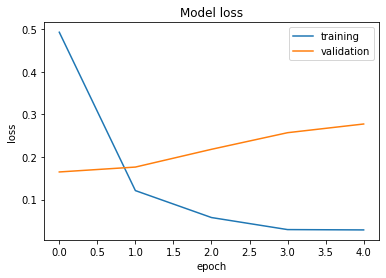

In [28]:
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper right')
plt.show()

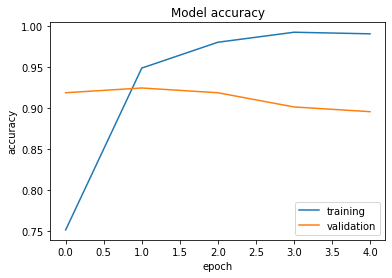

In [29]:
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print("test loss:", test_loss)
print("test accuracy:", test_acc)

576/576 [==============================] - 0s 229us/step
test loss: 0.26920495078795487
test accuracy: 0.890625
